In [13]:
import glob
import pandas as pd
import os

path = "../data/GeneratedLabelledFlows/TrafficLabelling/"

csv_files = glob.glob(os.path.join(path, "*.csv"))

print(f"Found {len(csv_files)} CSV files to merge.")

# Read and concatenate all CSV files into a single DataFrame
df = pd.concat(
    [pd.read_csv(f, low_memory=False, encoding='ISO-8859-1') for f in csv_files],
    ignore_index=True
)

# Shuffle the dataframe to ensure the data is mixed well before splitting
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Merged and shuffled DataFrame shape:", df.shape)

Found 8 CSV files to merge.
Merged and shuffled DataFrame shape: (3119345, 85)


In [14]:
#We should remove unnamed columns and columns that are completely empty
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(axis=1, how='all', inplace=True)

In [15]:
print(df.columns.tolist())

['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', 

In [16]:
# Strip column names to remove extra spaces
df.columns = df.columns.str.strip()

In [17]:
# Drop rows where the 'Label' column itself is missing

df.dropna(subset=['Label'], inplace=True)

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
import pandas as pd
import numpy as np

# Re-combining features and labels to keep them in sync during cleaning
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print("DataFrames re-combined for synchronized cleaning.")

DataFrames re-combined for synchronized cleaning.


In [20]:
def preprocess_dataframe(df):
    """Applies all cleaning, encoding, and preparation steps."""
    df_processed = df.copy()

    # Clean up column names by removing extra whitespace
    df_processed.columns = df_processed.columns.str.strip()

    # Convert the text-based 'Label' into a binary 0 or 1
    df_processed['Label'] = df_processed['Label'].apply(
        lambda x: 0 if isinstance(x, str) and x.strip().upper() == 'BENIGN' else 1
    )

    # These columns are identifiers and aren't useful for modeling
    drop_cols = ['Flow ID', 'Timestamp', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Protocol']
    df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns], inplace=True, errors='ignore')

    # Remove any other non-numeric columns that might remain
    non_numeric = df_processed.select_dtypes(include=['object']).columns
    df_processed.drop(columns=non_numeric, inplace=True)

    # Standardize infinite values to NaN so they can be removed
    df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Now, drop any row that has a missing value. Because we combined first, this removes the features and label together.
    df_processed.dropna(inplace=True)

    return df_processed

In [21]:
# Apply our preprocessing function to both the training and testing dataframes
train_clean_df = preprocess_dataframe(train_df)
test_clean_df = preprocess_dataframe(test_df)

print(f"Shape of cleaned training data: {train_clean_df.shape}")
print(f"Shape of cleaned testing data: {test_clean_df.shape}")

Shape of cleaned training data: (2262314, 78)
Shape of cleaned testing data: (565562, 78)


Calculating and visualizing feature correlation from training data...


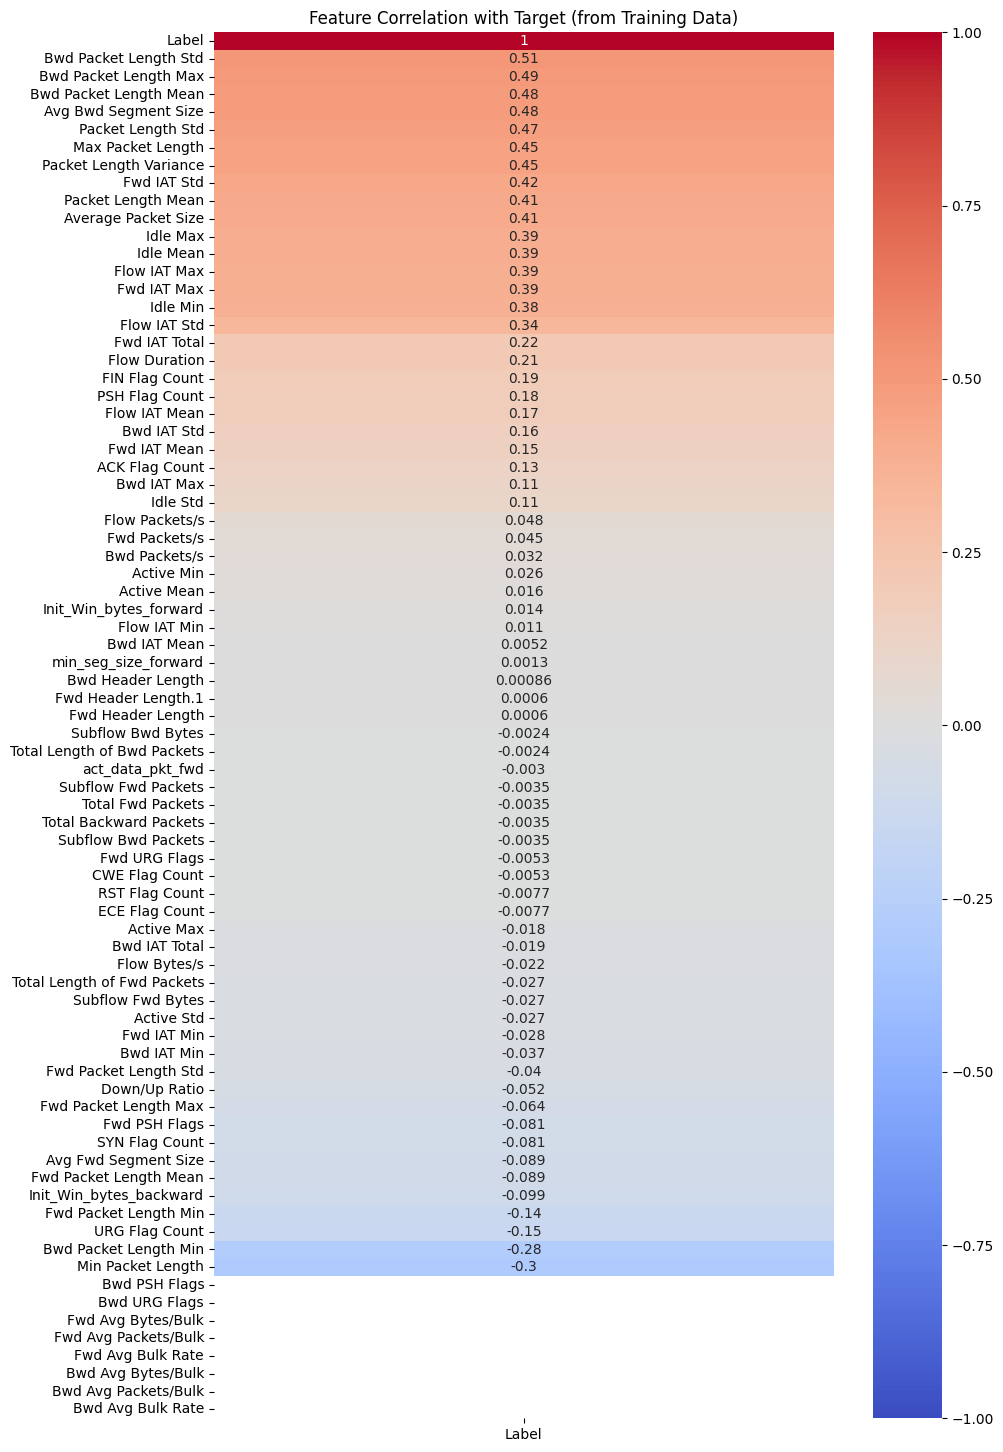

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Calculating and visualizing feature correlation from training data...")
corr_matrix = train_clean_df.corr()

# Let's visualize how each feature correlates with the target label
plt.figure(figsize=(10, 18))
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target (from Training Data)")
plt.show()

In [23]:
# Select features with a correlation absolute value greater than 0.1
corr_with_target = corr_matrix['Label']
strong_corr_features = corr_with_target[abs(corr_with_target) > 0.1].index.tolist()

# This is our final list of columns to use
final_columns = strong_corr_features

# Filter both dataframes to keep only these final columns
train_final = train_clean_df[final_columns]
test_final = test_clean_df[final_columns]

print(f"Selected {len(final_columns) - 1} features based on correlation.")
print(f"Final Train shape: {train_final.shape}, Final Test shape: {test_final.shape}")

Selected 30 features based on correlation.
Final Train shape: (2262314, 31), Final Test shape: (565562, 31)


In [24]:
import os
import pickle

output_dir = "../data/processed/"
os.makedirs(output_dir, exist_ok=True)

# Save the final, fully-processed datasets
train_final.to_csv(os.path.join(output_dir, "train_dataset.csv"), index=False)
test_final.to_csv(os.path.join(output_dir, "test_dataset.csv"), index=False)

# Saving the feature list ensures we can use the exact same features for inference later
features_to_save = [col for col in final_columns if col != 'Label']
with open(os.path.join(output_dir, 'selected_features.pkl'), 'wb') as f:
    pickle.dump(features_to_save, f)

print(f"\nPreprocessing complete. Final datasets and artifacts are saved to '{output_dir}'.")


Preprocessing complete. Final datasets and artifacts are saved to '../data/processed/'.
